In [17]:
# Import libraries and set size of plots
import json
from collections import Counter
from itertools import chain
from statistics import fmean

import pandas as pd
import plotly.express as px
import spacy
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en import stop_words

plt.rcParams['figure.figsize'] = [20, 5]
nlp = spacy.load("en_core_web_sm")

In [18]:
# Read data
dialogue_df = pd.read_csv("./../data/DIALOCONAN.csv").sort_values(by=["dialogue_id", "turn_id"])
knowledge_df = pd.read_csv("./../data/multitarget_KN_grounded_CN.csv")

print(f"Utterances in DIALOCONAN: {len(dialogue_df)}\n"
      f"Dialogues in DIALOCONAN: {len(dialogue_df['dialogue_id'].unique())}\n"
      f"HS-CN pairs in k-CONAN: {len(knowledge_df)}\n"
      f"\n"
      f"HS in DIALOCONAN: {len(dialogue_df['text'][dialogue_df['type'] == 'HS'])}\n"
      f"CN in DIALOCONAN: {len(dialogue_df['text'][dialogue_df['type'] == 'CN'])}\n"
      f"Unique HS in DIALOCONAN: {len(dialogue_df['text'][dialogue_df['type'] == 'HS'].unique())}\n"
      f"Unique CN in DIALOCONAN: {len(dialogue_df['text'][dialogue_df['type'] == 'CN'].unique())}\n"
      f"\n"
      f"Unique HS in k-CONAN: {len(knowledge_df['hate_speech'].unique())}\n"
      f"Unique CN in k-CONAN: {len(knowledge_df['counter_narrative'].unique())}\n"
      f"Unique knowledge in k-CONAN: {len(knowledge_df['knowledge_sentence'].unique())}\n"
      f"\n"
      f"Average utterances per dialogue in DIALOCONAN: {len(dialogue_df)} / {len(dialogue_df['dialogue_id'].unique())} = {len(dialogue_df) / len(dialogue_df['dialogue_id'].unique())}")


Utterances in DIALOCONAN: 16625
Dialogues in DIALOCONAN: 3059
HS-CN pairs in k-CONAN: 195

HS in DIALOCONAN: 8314
CN in DIALOCONAN: 8311
Unique HS in DIALOCONAN: 4771
Unique CN in DIALOCONAN: 6887

Unique HS in k-CONAN: 104
Unique CN in k-CONAN: 195
Unique knowledge in k-CONAN: 156

Average utterances per dialogue in DIALOCONAN: 16625 / 3059 = 5.434782608695652


In [19]:
# Calculate overlap between datasets
overlap_df = dialogue_df.merge(knowledge_df, how="inner", left_on="text", right_on="hate_speech", sort=True)
print(f"Matched utterances in k-DIALOCONAN: {len(overlap_df[['dialogue_id', 'turn_id']].drop_duplicates())}\n")
# overlap_df.head()

Matched utterances in k-DIALOCONAN: 100



In [20]:
# Basic statistics on overlap
print(f"Unique dialogues with knowledge matches: {len(overlap_df['dialogue_id'].unique())}\n"
      f"Unique utterances with knowledge matches: {len(overlap_df['text'].unique())}\n"
      f"\n"
      f"Unique HS with relevant knowledge: {len(overlap_df['hate_speech'].unique())}\n"
      f"Unique CN: {len(overlap_df['text'][dialogue_df['type'] == 'CN'].unique())}\n"
      f"Unique knowledge sentences: {len(overlap_df['knowledge_sentence'].unique())}\n"
      f"Unique k-CN: {len(overlap_df['counter_narrative'].unique())}\n")

Unique dialogues with knowledge matches: 98
Unique utterances with knowledge matches: 36

Unique HS with relevant knowledge: 36
Unique CN: 34
Unique knowledge sentences: 67
Unique k-CN: 77



Comparing num of knoweldge items vs counter-narratives:
	more knowledge:0
	less knowledge: 16
	equal knowledge: 82


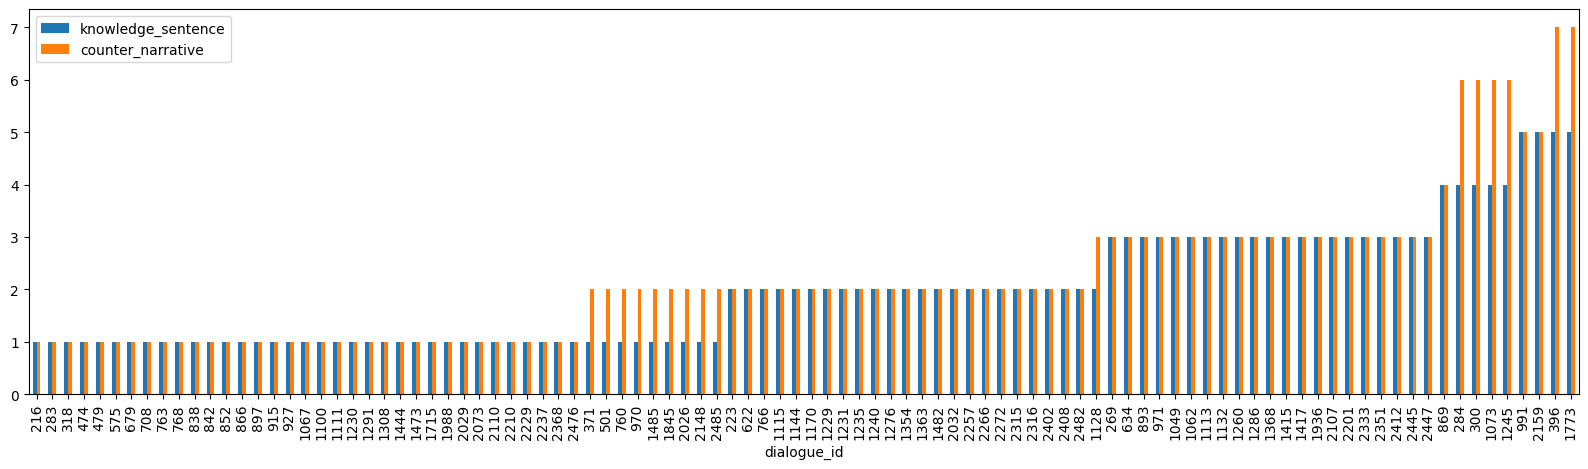

In [21]:
# See how many knowledge items there are per dialogue
per_dialogue_df = overlap_df.groupby(["dialogue_id"])[["knowledge_sentence", "counter_narrative"]].nunique()

# Check if we have more knowledge sentences than counter-narratives
more_k = per_dialogue_df[per_dialogue_df["knowledge_sentence"] > per_dialogue_df["counter_narrative"]]
less_k = per_dialogue_df[per_dialogue_df["knowledge_sentence"] < per_dialogue_df["counter_narrative"]]
equal_k = per_dialogue_df[per_dialogue_df["knowledge_sentence"] == per_dialogue_df["counter_narrative"]]

print(f"Comparing num of knoweldge items vs counter-narratives:\n"
      f"\tmore knowledge:{len(more_k)}\n"
      f"\tless knowledge: {len(less_k)}\n"
      f"\tequal knowledge: {len(equal_k)}")

# Visualize distribution
per_dialogue_df.sort_values(by=["knowledge_sentence", "counter_narrative"], inplace=True)
per_dialogue_df.plot.bar()
plt.savefig("./../plots/dialogue_knowledge_distribution.png")  #, bbox_inches="tight")

In [22]:
# Average knowledge and cn, per dialogue
avg_k_sentences = per_dialogue_df.mean()
print(f"Average knowledge items per dialogue: {avg_k_sentences['knowledge_sentence']}")
print(f"Average knowledge based counter-narratives per dialogue: {avg_k_sentences['counter_narrative']}")

Average knowledge items per dialogue: 1.989795918367347
Average knowledge based counter-narratives per dialogue: 2.2142857142857144


In [23]:
# Create dataset as in DSTC: {dialogue_id}
logs = []

# Looping helpers
prev_row = None
dialogue_id = 0
utterances = []
grounded_dialogue = False

for i, row in dialogue_df.iterrows():
    # determine if we are in a new dialogue. if so, add the last one to the logs
    if row["dialogue_id"] != dialogue_id:
        dialogue = {"dialogue_id": prev_row["dialogue_id"],
                    "hs_target": prev_row["TARGET"],
                    "dialogue_source": prev_row["source"],
                    "knowledge_grounded": grounded_dialogue,
                    "utterances": utterances}
        logs.append(dialogue)
        utterances = []
        grounded_dialogue = False

    # gather labels
    match = knowledge_df[["knowledge_sentence", "counter_narrative"]][knowledge_df["hate_speech"] == row["text"]]
    grounded_dialogue = len(match) > 0 or grounded_dialogue

    knowledge_items = {"knowledge_sentence": match["knowledge_sentence"].drop_duplicates().to_list(),
                       "counter_narrative": match["counter_narrative"].drop_duplicates().to_list()}

    # Create utterance object and add it to the utterances list
    utterance = {"turn_id": row["turn_id"], "speaker": row["type"], "text": row["text"],
                 "knowledge_grounded": len(match) > 0, "knowledge": knowledge_items}
    utterances.append(utterance)

    # move variables along the iteration
    dialogue_id = row["dialogue_id"]
    prev_row = row

    # add last dialogue
    if i == len(dialogue_df) - 1:
        dialogue = {"dialogue_id": prev_row["dialogue_id"],
                    "hs_target": prev_row["TARGET"],
                    "dialogue_source": prev_row["source"],
                    "knowledge_grounded": grounded_dialogue,
                    "utterances": utterances}
        logs.append(dialogue)

filename = "./../data/KDIALOCONAN_gold.json"
with open(filename, 'w', encoding='utf-8') as f:
    json.dump(logs, f, ensure_ascii=False, indent=4)
print(f"Wrote dataset to file: {filename}")

Wrote dataset to file: ./../data/KDIALOCONAN_gold.json


In [24]:
logs_grounded = [dialogue for dialogue in logs if dialogue["knowledge_grounded"]]

filename = "./../data/KDIALOCONAN_grounded_gold.json"
with open(filename, 'w', encoding='utf-8') as f:
    json.dump(logs_grounded, f, ensure_ascii=False, indent=4)
print(f"Wrote dataset to file: {filename}")

Wrote dataset to file: ./../data/KDIALOCONAN_grounded_gold.json


In [25]:
def report_stats_dataset(dataset, name=''):
    hs = [u['text'] for d in dataset for u in d['utterances'] if u['speaker'] == 'HS']
    cn = [u['text'] for d in dataset for u in d['utterances'] if u['speaker'] == 'CN']
    k = sum([u['knowledge']['knowledge_sentence'] for d in dataset for u in d['utterances']], [])
    kcn = sum([u['knowledge']['counter_narrative'] for d in dataset for u in d['utterances']], [])

    print(f"Dialogues in {name}: {len(dataset)}\n"
          f"Utterances in {name}: {sum([len(d['utterances']) for d in dataset])}\n"
          f"Utterances (HS) with knowledge in {name}: {sum([int(u['knowledge_grounded']) for d in dataset for u in d['utterances']])}\n"
          f"\n"
          f"HS in {name}: {sum([int(u['speaker'] == 'HS') for d in dataset for u in d['utterances']])}\n"
          f"CN in {name}: {sum([int(u['speaker'] == 'CN') for d in dataset for u in d['utterances']])}\n"
          f"Knowledge items in {name}: {sum([len(u['knowledge']['knowledge_sentence']) for d in dataset for u in d['utterances']])}\n"
          f"k-CN in {name}: {sum([len(u['knowledge']['counter_narrative']) for d in dataset for u in d['utterances']])}\n"
          f"\n"
          f"Unique HS in {name}: {len(set([u['text'] for d in dataset for u in d['utterances'] if u['speaker'] == 'HS']))}\n"
          f"Unique CN in {name}: {len(set([u['text'] for d in dataset for u in d['utterances'] if u['speaker'] == 'CN']))}\n"
          f"Unique knowledge items in {name}: {len(set(sum([u['knowledge']['knowledge_sentence'] for d in dataset for u in d['utterances']], [])))}\n"
          f"Unique k-CN in {name}: {len(set(sum([u['knowledge']['counter_narrative'] for d in dataset for u in d['utterances']], [])))}\n"
          f"\n"
          f"Average utterances per dialogue {name}: {fmean([len(d['utterances']) for d in dataset])}\n"
          f"Average utterances with knowledge per dialogue {name}: {fmean([len([ug for ug in d['utterances'] if ug['knowledge_grounded']]) for d in dataset])}\n"
          f"Average knowledge items per dialogue {name}: {fmean([sum([len(u['knowledge']['knowledge_sentence']) for u in d['utterances']]) for d in dataset])}\n"
          f"Average k-CN per dialogue {name}: {fmean([sum([len(u['knowledge']['counter_narrative']) for u in d['utterances']]) for d in dataset])}\n"
          f"\n"
          f"Average knowledge items per utterance in {name}: {fmean([len(u['knowledge']['knowledge_sentence']) for d in dataset for u in d['utterances']])}\n"
          f"Average k-CN per utterance in {name}: {fmean([len(u['knowledge']['counter_narrative']) for d in dataset for u in d['utterances']])}\n"
          f"\n"
          f"Average knowledge items per HS in {name}: {fmean([len(u['knowledge']['knowledge_sentence']) for d in dataset for u in d['utterances'] if u['speaker'] == 'HS'])}\n"
          f"Average k-CN per HS in {name}: {fmean([len(u['knowledge']['counter_narrative']) for d in dataset for u in d['utterances'] if u['speaker'] == 'HS'])}\n")

    return hs, cn, k, kcn


hs, cn, k, kcn = report_stats_dataset(logs, 'k-DIALOCONAN')

Dialogues in k-DIALOCONAN: 3059
Utterances in k-DIALOCONAN: 16629
Utterances (HS) with knowledge in k-DIALOCONAN: 100

HS in k-DIALOCONAN: 8316
CN in k-DIALOCONAN: 8313
Knowledge items in k-DIALOCONAN: 195
k-CN in k-DIALOCONAN: 217

Unique HS in k-DIALOCONAN: 4770
Unique CN in k-DIALOCONAN: 6885
Unique knowledge items in k-DIALOCONAN: 67
Unique k-CN in k-DIALOCONAN: 77

Average utterances per dialogue k-DIALOCONAN: 5.43609022556391
Average utterances with knowledge per dialogue k-DIALOCONAN: 0.032690421706440015
Average knowledge items per dialogue k-DIALOCONAN: 0.06374632232755803
Average k-CN per dialogue k-DIALOCONAN: 0.07093821510297482

Average knowledge items per utterance in k-DIALOCONAN: 0.011726501894281075
Average k-CN per utterance in k-DIALOCONAN: 0.01304949185158458

Average knowledge items per HS in k-DIALOCONAN: 0.023448773448773448
Average k-CN per HS in k-DIALOCONAN: 0.026094276094276093



In [26]:
hs_g, cn_g, k_g, kcn_g = report_stats_dataset(logs_grounded, 'k-DIALOCONAN (filtered)')

Dialogues in k-DIALOCONAN (filtered): 98
Utterances in k-DIALOCONAN (filtered): 546
Utterances (HS) with knowledge in k-DIALOCONAN (filtered): 100

HS in k-DIALOCONAN (filtered): 273
CN in k-DIALOCONAN (filtered): 273
Knowledge items in k-DIALOCONAN (filtered): 195
k-CN in k-DIALOCONAN (filtered): 217

Unique HS in k-DIALOCONAN (filtered): 156
Unique CN in k-DIALOCONAN (filtered): 257
Unique knowledge items in k-DIALOCONAN (filtered): 67
Unique k-CN in k-DIALOCONAN (filtered): 77

Average utterances per dialogue k-DIALOCONAN (filtered): 5.571428571428571
Average utterances with knowledge per dialogue k-DIALOCONAN (filtered): 1.0204081632653061
Average knowledge items per dialogue k-DIALOCONAN (filtered): 1.989795918367347
Average k-CN per dialogue k-DIALOCONAN (filtered): 2.2142857142857144

Average knowledge items per utterance in k-DIALOCONAN (filtered): 0.35714285714285715
Average k-CN per utterance in k-DIALOCONAN (filtered): 0.3974358974358974

Average knowledge items per HS in k-

In [27]:
corpus_columns = zip([hs_g, cn_g, k_g, kcn_g], ['HS', 'CN', 'K', 'KCN'])

# Get tfidf features
tfidf_df = pd.DataFrame(columns=['HS', 'CN', 'K', 'KCN'])
k_features = 10

for corpus, column in corpus_columns:
    vectorizer = TfidfVectorizer(token_pattern=r'(?u)\b[A-Za-z]+\b', max_features=k_features, stop_words='english')
    _ = vectorizer.fit_transform(corpus)
    tfidf_df[column] = vectorizer.get_feature_names_out()[:k_features]

tfidf_df

,HS,CN,K,KCN
0,children,don,islamic,don
1,don,jews,jews,gays
2,europe,like,muslim,jews
3,gays,muslims,muslims,like
4,hate,people,orientation,muslims
5,jews,religion,rights,s
6,muslims,s,s,sexual
7,s,society,said,society
8,t,t,sexual,t
9,want,world,women,world


In [28]:
# Get type token ratio
corpus_columns = zip([hs_g, cn_g, k_g, kcn_g], ['HS', 'CN', 'K', 'KCN'])
type_token_df = pd.DataFrame(columns=['HS', 'CN', 'K', 'KCN'])

for corpus, column in corpus_columns:
    tokens = []
    for doc in nlp.pipe(corpus):
        this_tokens = [token.text for sent in doc.sents for token in sent]
        tokens.extend(this_tokens)
    type_token_df._set_value(0, column, (len(set(tokens)) / len(tokens)) * 100)

type_token_df

,HS,CN,K,KCN
0,16.026073,17.268206,9.338456,11.50358


In [29]:
def find_ngrams(input_list, n, remove_stopwords=True):
    if remove_stopwords:
        input_list = [t for t in input_list if t not in stop_words.STOP_WORDS]
    return list(zip(*[input_list[i:] for i in range(n)]))


def get_ngram_count(df, column, ngram_size=2, topk=20):
    # create ngrams
    df['ngrams'] = df[column].map(lambda x: find_ngrams(x.split(" "), ngram_size) if type(x) == str else x)
    ngrams = [x for x in df['ngrams'].tolist() if type(x) == list]
    ngrams = list(chain(*ngrams))

    # get ngram frequency
    ngram_counts = Counter(ngrams)
    ngram_counts = pd.DataFrame.from_dict(ngram_counts, orient='index', columns=['count'])

    # format output
    ngram_counts.sort_values(by="count", inplace=True, ascending=False)
    ngram_counts = ngram_counts[:topk]
    ngram_counts.reset_index(inplace=True)

    return ngram_counts

# Get most frequent trigrams
corpus_columns = zip([hs_g, cn_g, k_g, kcn_g], ['HS', 'CN', 'K', 'KCN'])

for corpus, column in corpus_columns:
    trigram_df = pd.DataFrame({"text": corpus})
    trigrams = get_ngram_count(trigram_df, 'text', ngram_size=3)

    trigrams["A"] = trigrams["index"].apply(lambda x: x[0])
    trigrams["B"] = trigrams["index"].apply(lambda x: x[1])
    trigrams["C"] = trigrams["index"].apply(lambda x: x[2])
    trigrams["G"] = trigrams["count"]
    trigrams.drop(columns=["index", "count"], inplace=True)

    # print(column)
    # print(trigrams)

    fig = px.sunburst(trigrams, path=['A', 'B', 'C'], values='G')
    fig.write_html(f"./../plots/sunburst_distribution_{column}.html")